In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
benchmarks = {}
for celltype in ['5HT', 'GABA', 'mPFC']:
    benchmarks[celltype] = {
        'Md': pd.read_csv('{}_goodcellsbenchmark_Md_8.csv'.format(celltype)),
        'R2V': pd.read_csv('{}_goodcellsbenchmark_R2_V.csv'.format(celltype)),
        'R2dV': pd.read_csv('{}_goodcellsbenchmark_R2_dV.csv'.format(celltype))
    }

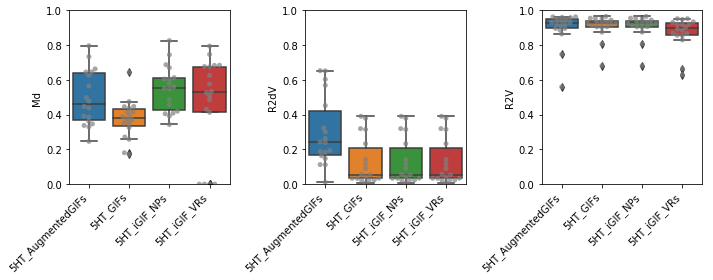

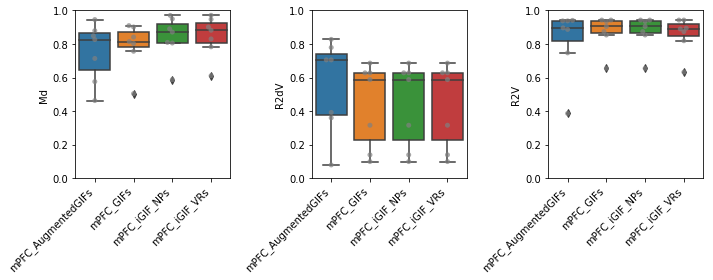

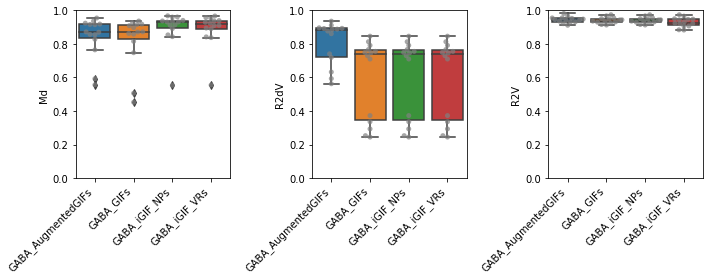

In [3]:
for celltype in benchmarks:
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))
    axes = axes.flatten().tolist()
    
    for i, benchtype in enumerate(benchmarks[celltype]):
        axes[i].set_ylim(0, 1)
        chart = sns.boxplot(
            x='variable', y='value', data=benchmarks[celltype][benchtype].melt(id_vars=['Cell']), 
            ax=axes[i]
        )
        sns.swarmplot(
            x='variable', y='value', data=benchmarks[celltype][benchtype].melt(id_vars=['Cell']), 
            ax=axes[i], color='gray', alpha=0.7
        )
        axes[i].set_xticklabels(chart.get_xticklabels(), rotation=45, ha='right')
        axes[i].set_ylabel(benchtype)
        axes[i].set_xlabel('')
    
    plt.tight_layout()